# Runge-Kutta Tutorials Code Part II: Covid 19 

In [1]:
%matplotlib widget

import ipywidgets as widgets
from ipywidgets import interact, fixed

In [2]:
%matplotlib widget

import ipywidgets as widgets
from ipywidgets import interact, fixed
import numpy as np
from numpy import pi
from numpy.linalg import solve, norm    
import matplotlib.pyplot as plt

# Use a funny plotting style
plt.xkcd()

newparams = {'figure.figsize': (6.0, 6.0),
             'axes.grid': True,
             'lines.markersize': 8, 
             'lines.linewidth': 2,
             'font.size': 14}
plt.rcParams.update(newparams)

## Problem 1 SIHR model

**a)** Write down the final ODE system for the SIHR model developed during the first breakout session.
   Denote the rates for the transition $I \overset{\gamma_h}{\to} H$, $I \overset{\gamma_r}{\to} R$,
   and $H \overset{\delta}{\to} R$
   by $\gamma_h$ and $\gamma_r$, $\delta$, respectively. 
   
**b)** As the SIHR model is a refinement of the SIR model where we
   want to distinguish between infectious and hospitialized individuals, we assume the same total $\gamma$
   as for the simpler SIR model; that is,
   $$
   \gamma_r + \gamma_h =: \gamma = 1/18
   $$
   Assume that
   *  that 3.5% of all infected individuals will be hospitalized which means that $\gamma_h = 0.035\gamma$
   *  hospitalized individuals stay 14 days in the hospital on average, that is $\delta = 1/14$
   *  St. Olav's hospital has roughly 1000 beds with roughly 80% of them being occupied
   
   Use the same initial condition as in the Trondheim scenario as in the lecture, choose a tolerance $\mathrm{tol}$ such    that your numerical solutions are not off by more than 10 persons.
   Now compute and plot the solution $S, I, H, R$ using both the adaptive Euler-Heun and Fehlberg's method.
   Record and state the number of steps you needed with Euler-Heun vs Fehlberg.
   What is (approximately) the largest basic reproduction number $R_0$ for which we will not exceed the maximal number of    
   available beds?

**Solution.**

Note that the solution code provided below uses some more sophisticated Jupyter widgets features, but it is just used 
as extra interface sugar. We will use a simple slider interface which sets the basic reproduction number $R_0$ and then automatically updates
the solution plots.

Final answers:
* $\mathrm{tol} = 5 \cdot 10^{-5}$
* Euler-Heun uses roughly 
* $R_0 \approx 1.45$  

Specify the model:

In [3]:
# define SIHR class similar to SIR before
class SIHR:
    def __init__(self, beta, gamma_r, gamma_h, delta):
        self.beta = beta # infectional rate
        self.gamma_r = gamma_r # removal rate
        self.gamma_h = gamma_h # removal rate
        self.delta = delta
    
    def __call__(self, t, y):
        return np.array([-self.beta*y[0]*y[1],
                          self.beta*y[0]*y[1] - self.gamma_r*y[1]-self.gamma_h*y[1],
                          self.gamma_h*y[1] - self.delta*y[2],
                          self.gamma_r*y[1]+self.gamma_h*y[2]])

# initial data
# Trondheim has 200.000 inhabitants we start with 1 infected person
N = 2.0e5
I_0 = 1/N
S_0 = 1 - I_0
H_0 = 0
R_0 = 0

y0 = np.array([S_0, 
               I_0,
               H_0,
               R_0])
Nyears = 2
t0, T = 0, Nyears*365 # days, we consider 2 years year

Define Euler-Heun and Fehlberg solvers defined by 
$$
\begin{array}{c|cc} 0 & & \\ 1 & 1 &   \\ \hline & 1 & 0 \\ \hline \displaystyle & \frac{1}{2} &  \frac{1}{2} 
 \end{array}
$$
or 
the
embedded Runge-Kutta 4(3) variant
due to **Fehlberg**:
$$
\begin{array}{c|ccccc}
      0 & 0 & 0 & 0 & 0 & 0
      \\ 
      \frac{1}{2} & \frac{1}{2} & 0 & 0 & 0 & 0
      \\ 
      \frac{1}{2} & 0 & \frac{1}{2} & 0 & 0 & 0
      \\
      1 &  0 & 0 & 1 & 0 & 0
      \\
      1 & \frac{1}{6} & \frac{1}{3} & \frac{1}{3} & \frac{1}{6} & 0 
      \\
      \hline 
      & \frac{1}{6} & \frac{1}{3} & \frac{1}{3} & 0 & \frac{1}{6} 
      \\
     \hline 
      & \frac{1}{6} & \frac{1}{3} & \frac{1}{3} & \frac{1}{6} & 0
\end{array}
$$
using ```EmbeddedExplicitRungeKutta``` solver.

In [4]:
from rkm import EmbeddedExplicitRungeKutta

#Heun-Euler
a    = np.array([[0,   0],
                 [1., 0]])
bhat = np.array([1/2, 1/2.])
b    = np.array([1, 0.])
c = np.array([0., 1])
order = 1

euler_heun = EmbeddedExplicitRungeKutta(a, b, c, bhat, order)

#Fehlberg method
a = np.array([[0.0, 0,   0,   0,   0],
              [1/2, 0,   0,   0,   0],
              [0, 1/2,   0,   0,   0],
              [0,   0,   1,   0,   0],
              [1/6, 1/3, 1/3, 1/6, 0]])
b =  np.array([1/6, 1/3, 1/3, 0, 1/6])
bhat = np.array([1/6, 1/3, 1/3, 1/6, 0])
c = np.array([0.,
               1/2,
               1/2,
               1,
               1])
order = 3
fehlberg = EmbeddedExplicitRungeKutta(a, b, c, bhat, order)

# max number of steps
Nmax = 10000
tol = 1.0e-5

In [5]:
# Prepare plot
Nbeds = 1000
Nfree_beds = 200

def plot_dynamics_sihr(r0, solver, ax):
    # Orginal removal rate from SIR model
    gamma = 1/18.
    beta = r0*gamma
    # We split it into gamma = gamma_r + gamma_h
    # assuming that 3.5 % are hospitalized
    gamma_h =0.035*gamma
    gamma_r = gamma - gamma_h
    # Assume 14 days of hospitilization
    delta = 1./14

    # Define a model for given r0
    sihr = SIHR(beta=beta, gamma_h=gamma_h, gamma_r=gamma_r, delta=delta)

    # Solve
    ts, ys = solver(y0, t0, T, sihr, Nmax, tol)
    ax[0].clear()
    ax[0].plot(ts, ys, "-o", markersize=3)
    ax[0].legend(["S", "I", "H", "R"])
    ax[0].set_xlim(0,Nyears*365)
    ax[0].set_ylim(0, 1.0)
    ax[0].set_xlabel("Days")
    ax[0].set_ylabel("Fraction of population")

    ax[1].clear()
    ax[1].plot(ts, 2e5*ys[:,2], "-og", markersize=3, label="H")
    ax[1].legend()
    ax[1].set_xlabel("Days")
    ax[1].set_ylabel("Number of hospitalized persons")
    ax[1].set_xlim(0,Nyears*365)
    ax[1].set_ylim(0, Nbeds)
    ax[1].hlines([Nfree_beds], t0,T, colors="r", linestyles="dashed")
    ax[1].annotate('Max capacity of \nadditional available beds', 
             xy=(500, Nfree_beds), xytext=(-50, 50), 
             textcoords="offset points",
             arrowprops=dict(arrowstyle="simple",facecolor='black', 
                             relpos=(0.315,0)))
    print(f"Maximum of additional Covid 19 caused hospitalization: {np.abs(ys[:,2]).max()*200000}") 

interactive(children=(FloatSlider(value=2.0, description='r0', max=3.0, min=1.0, step=0.01), Output()), _dom_c…

<function __main__.plot_dynamics_sihr(r0, solver, ax)>

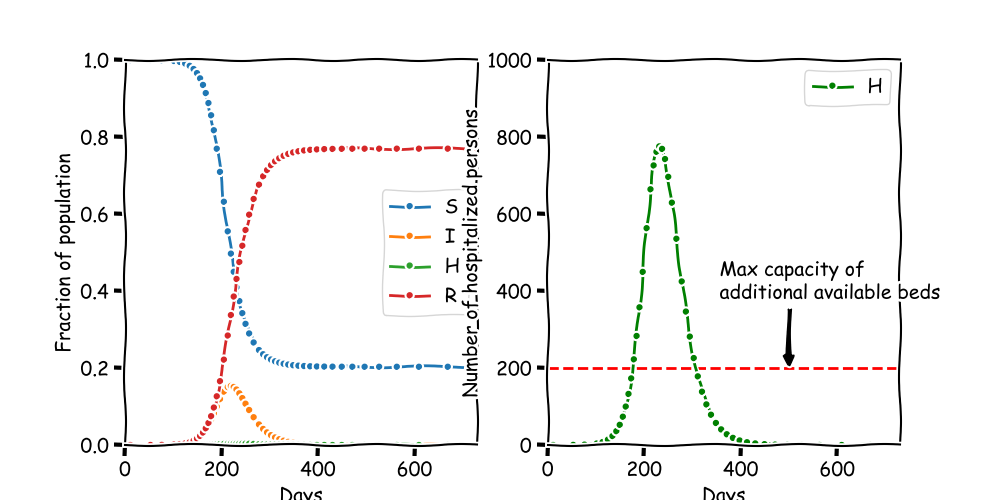

In [7]:
newparams = {'figure.figsize': (10.0, 5.0)}
plt.rcParams.update(newparams)

plt.close()
fig, ax = plt.subplots(1,2)
widgets.interact(plot_dynamics_sihr, r0=(1.0, 3.0, 0.01), solver=fixed(fehlberg), ax=fixed(ax))

## Problem 2 SIHRt model

Redo problem 1, but this time develop and use an extension the SIHR model to account for time-limited immunity, assuming 1 year of immunity for each recovered person. Consider a time-period of 5 years and
find out how many "infection waves" will occur where the maximum capacity of beds are exceeded. 

**Solution.**

Final answers are:
  * For $R_0=2$ there are 2 waves, one around Day 250 and one around Day 805
  * 

In [ ]:
class SIHRt:
    def __init__(self, beta, gamma_r, gamma_h, delta, sigma):
        self.beta = beta # infectional rate
        self.gamma_r = gamma_r # removal rate
        self.gamma_h = gamma_h # removal rate
        self.delta = delta
        self.sigma = sigma
    
    def __call__(self, t, y):
        return np.array([-self.beta*y[0]*y[1]+self.sigma*y[3],
                          self.beta*y[0]*y[1] - self.gamma_r*y[1]-self.gamma_h*y[1],
                          self.gamma_h*y[1] - self.delta*y[2],
                          self.gamma_r*y[1]+self.gamma_h*y[2]-self.sigma*y[3]])

In [ ]:
# Prepare plot
Nbeds = 1000
Nfree_beds = 200

Nyears = 5
t0, T = 0, Nyears*365 # days, we consider 5 years year

def plot_dynamics_sihrt(r0, solver, ax):
    ##### Data for the SIHRt model
    # Orginal removal rate from SIR model
    # We split it into gamma = gamma_r + gamma_h
    # assuming that 3.5 % are hospitalized
    gamma = 1/18.
    beta = r0*gamma
    gamma_h =0.035*gamma
    gamma_r = gamma - gamma_h
    # Assume 14 days of hospitilization
    delta = 1./14
    # One year of immunization
    sigma = 1/365.

    # Define a model for given r0
    sihrt = SIHRt(beta=beta, gamma_h=gamma_h, gamma_r=gamma_r, delta=delta, sigma=sigma)

    # Solve
    ts, ys = solver(y0, t0, T, sihrt, Nmax, tol)
    ax[0].clear()
    ax[0].plot(ts, ys, "--", markersize=3)
    ax[0].legend(["S", "I", "H", "R"])
    ax[0].set_xlim(0,Nyears*365)
    ax[0].set_ylim(0, 1.0)
    ax[0].set_xlabel("Days")
    ax[0].set_ylabel("Fraction of population")

    ax[1].clear()
    ax[1].plot(ts, 2e5*ys[:,2], "--g", markersize=3, label="H")
    ax[1].legend()
    ax[1].set_xlabel("Days")
    ax[1].set_ylabel("Number of hospitalized persons")
    ax[1].set_xlim(0,Nyears*365)
    ax[1].set_ylim(0, Nbeds)
    ax[1].hlines([Nfree_beds], t0,T, colors="r", linestyles="dashed")
    ax[1].annotate('Max capacity of \nadditional available beds', 
             xy=(500, Nfree_beds), xytext=(-50, 50), 
             textcoords="offset points",
             arrowprops=dict(arrowstyle="simple",facecolor='black', 
                             relpos=(0.315,0)))
    print(f"Maximum of additional Covid 19 caused hospitalization: {np.abs(ys[:,2]).max()*200000}") 

In [ ]:
plt.close()
fig, ax = plt.subplots(2,1)
widgets.interact(plot_dynamics_sihrt, r0=(1.0, 3.0, 0.01), solver=fixed(fehlberg), ax=fixed(ax))

## Problem 3 (recommended): SIHRVt model

**Todo:** Finish problem set

*  Include different vaccination models (linear vs exponential? linear is probably more   
      realistic?)
* Model different starting points of the vaccination campaign

In [ ]:
class SIHRVt:
    def __init__(self, beta, gamma_r, gamma_h, delta, sigma, nu):
        self.beta = beta # infectional rate
        self.gamma_r = gamma_r # removal rate
        self.gamma_h = gamma_h # removal rate
        self.delta = delta
        self.sigma = sigma
        self.nu = nu
    
    def __call__(self, t, y):
        return np.array([-self.beta*y[0]*y[1] - self.nu*y[0] + self.sigma*(y[3]+y[4]),
                          self.beta*y[0]*y[1] - self.gamma_r*y[1]-self.gamma_h*y[1],
                          self.gamma_h*y[1] - self.delta*y[2],
                          self.gamma_r*y[1]+self.gamma_h*y[2]-self.sigma*y[3],
                          self.nu*y[0] - self.sigma*y[4]])
%matplotlib widget
##### Data for the SIR model
# denote basic reproduction number by r0
r0 = 2 
# Orginal removal rate from SIR model
# We split it into gamma = gamma_r + gamma_h
# assuming that 3.5 % are hospitalized
gamma = 1/18.
beta = r0*gamma
gamma_h =0.035*gamma
gamma_r = gamma - gamma_h
# Assume 14 days of hospitilization
delta = 1./14
# One year of immunization
sigma = 1./365
# nu vaccination fraction
nu = 0.002

# Define a model
sihrvt = SIHRVt(beta=beta, gamma_h=gamma_h, gamma_r=gamma_r, delta=delta, sigma=sigma, nu=nu)

# Trondheim has 200.000 inhabitants we start with 1 infected person
I_0 = 1/200000
S_0 = 1 - I_0
H_0 = 0
R_0 = 0
V_0 = 0


y0 = np.array([S_0, 
               I_0,
               H_0,
               R_0,
               V_0])

#
t0, T = 0, 10*365 # days, we consider 3 years year

#### %matplotlib widget
Nmax = 10000
tol = 1.0e-6
ts, ys = fehlberg(y0, t0, T, sihrvt, Nmax, tol)

fig, ax = plt.subplots(2,1)
ax[0].plot(ts, ys, "-o", markersize=3)
ax[0].legend(["S", "I", "H", "R", "V"])
ax[0].set_xlabel("Days")
ax[0].set_ylabel("Fraction of population")

# ax[0]
# Plot number of hopitalization against month
ax[1].plot(ts, 2e5*ys[:,2], "-o", markersize=3)
ax[1].legend(["H"])
ax[1].set_xlabel("Days")
ax[1].set_ylabel("Number of hospitalized persons")
print(f"Maximum of additional Covid 19 caused hospitalization: {np.abs(ys[:,2]).max()*200000}") 

In [ ]:
from scipy.integrate import solve_ivp
sol = solve_ivp(sihrvt, [t0, T], y0, method="Radau")
plt.figure()
plt.plot(sol.t, sol.y[2])

In [ ]:
newparams = {'figure.figsize': (12.0, 6.0),
             'axes.grid': True,
             'lines.markersize': 8, 
             'lines.linewidth': 2,
             'font.size': 14}
plt.rcParams.update(newparams)

import numpy as np 
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

def solver_wrapper(r0):
    # Data for the SIR model
    gamma = 1/18.
    beta = r0*gamma
    # Define rhs for ODE
    sir = SIR(beta=beta, gamma=gamma)
    # Trondheim has 200.000 inhabitants we start with 1 infected person
    I_0 = 1/200000
    S_0 = 1 - I_0

    y0 = np.array([S_0, 
                   I_0,
                   R_0])

    t, T = 0, 365 # days, we consider a whole year
    Nmax = 10000
    tol = 1.0e-3
    ts, ys = fehlberg(y0, t0, T, sir, Nmax, tol)
    plt.plot(ts, ys, "-o", markersize=3)
    plt.legend(["S", "I", "R"])
    plt.title(f"$R_0$ = {r0}")
    plt.xlabel("Days")
    plt.ylabel("Fraction of population")

In [ ]:
slider = widgets.FloatSlider(min = 1,max = 4,step = 0.1, description="R_0", value = 3.0)
inter = interact(solver_wrapper, r0=slider)